In [6]:
import pandas as pd
import numpy as np
import json
import os
import operator
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import utils

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(24, 14)}, font_scale=2)

# Wikipages Dataset

In [7]:
def update_df(df, scores_path):
    '''
    Given a wikipages queries dataframe `df` and its respective NDCG `scores_path`
    update df to map the NDCG scores @k for each wikipage
    '''
    for file in os.listdir(scores_path):
        with open(scores_path + file, 'r') as f:
            scores_dict = json.load(f)

        wikipage_id_to_score = {}
        for wikipage_id in scores_dict:
            wikipage_id_to_score[int(wikipage_id)] = scores_dict[wikipage_id]['ndcg']
        
        k = file.split('_')[-1].split('.')[0]
        df['ndcg@'+k] = np.nan
        df['ndcg@'+k] = df['wikipage_id'].map(wikipage_id_to_score)

    return df

def get_query_df_dict(query_df_base_dir, score_paths_base_dir, min_tuple_width, mode, tuples_per_query_list):
    # Dictionary keyed by the number of tuples per query to the query dataframe that contains the NDCG scores at various k values
    query_df_dict = {}

    for tuples_per_query in tuples_per_query_list:
        df = pd.read_pickle(query_df_base_dir+'minTupleWidth_2_tuplesPerQuery_'+str(tuples_per_query)+'.pickle')  
        scores_path = score_paths_base_dir + 'minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_' + str(tuples_per_query) + '/' + mode + '/'

        query_df_dict[tuples_per_query] = update_df(df, scores_path)
    
    return query_df_dict

def get_mean_ndcg_scores_at_k(df_dict, top_k_vals, tuples_per_query_list):
    mean_ndcg_scores_at_k = {}
    for tuples_per_query in tuples_per_query_list:
        mean_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].mean() for k in top_k_vals]
    return mean_ndcg_scores_at_k

In [8]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/filtered_queries/'
min_tuple_width=2
tuples_per_query_list = [1, 2, 5, 10]
top_k_vals = [5,10,15,20,50,100,150,200]

## Search Mode: Adjusted Jaccard of DBpedia Types

In [4]:
search_mode='adjusted_jaccard'
adj_jaccard_score_paths_base_dir = 'eval_over_search_output/filtered_queries/adjusted_jaccard/'

# Updated Dataframes for Wikipages with Categories (Adjusted Jaccard)
query_df_adjusted_jaccard_categories = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

# Updated Dataframes for Wikipages with Categories (Adjusted Jaccard)
query_df_adjusted_jaccard_navigation_links = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_navigation_links',
    tuples_per_query_list=tuples_per_query_list
)

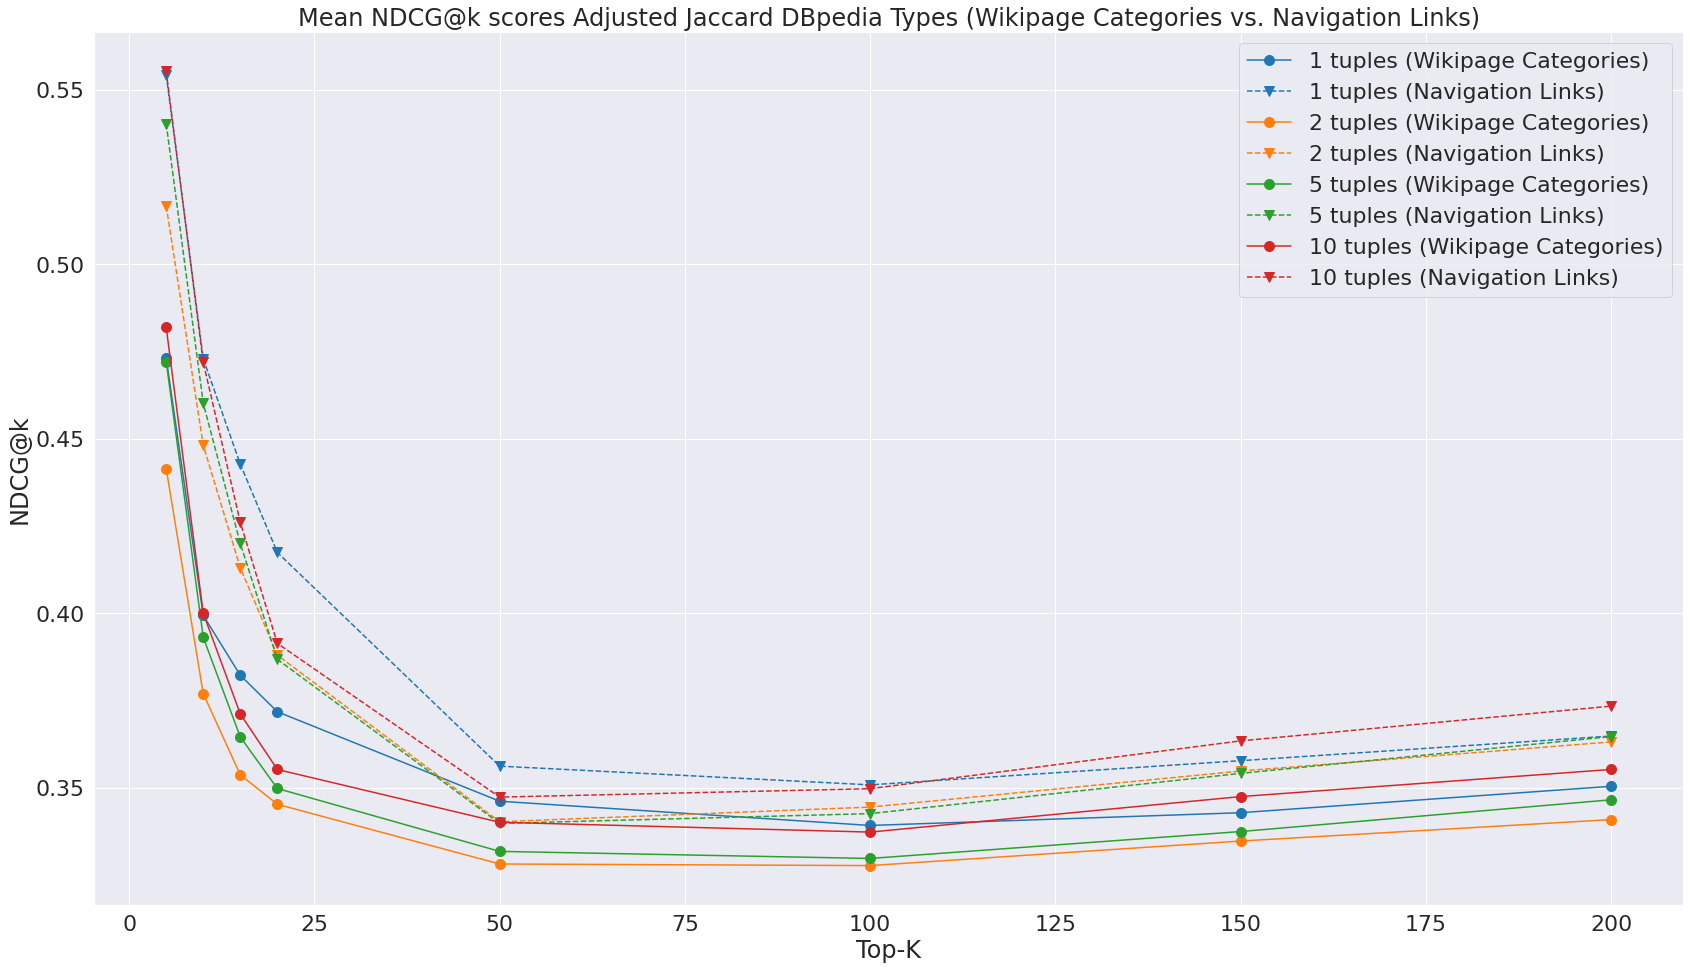

In [5]:
# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
mean_ndcg_scores_at_k_adjusted_jaccard_categories = get_mean_ndcg_scores_at_k(query_df_adjusted_jaccard_categories, top_k_vals, tuples_per_query_list)
mean_ndcg_scores_at_k_adjusted_jaccard_navigation_links = get_mean_ndcg_scores_at_k(query_df_adjusted_jaccard_navigation_links, top_k_vals, tuples_per_query_list)

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_categories[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_navigation_links[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Navigation Links)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard DBpedia Types (Wikipage Categories vs. Navigation Links)');plt.tight_layout()
plt.savefig('figures/filtered_queries/topk_ndcg@k_adjusted_jaccard_types_categories_vs_navigation_links.svg')

## Search Mode: Embeddings

In [31]:
scores_base_dir = 'eval_over_search_output/filtered_queries/embeddings/'
embedding_similarity_functions=['norm_cos']

embeddings_query_dfs_dict = {}
for sim_func in embedding_similarity_functions:
    embeddings_query_dfs_dict[sim_func] = {}
    embeddings_query_dfs_dict[sim_func]['jaccard_categories'] = get_query_df_dict(
                                                                    query_df_base_dir=query_df_base_dir,
                                                                    score_paths_base_dir=scores_base_dir+sim_func+'/',
                                                                    min_tuple_width=min_tuple_width,
                                                                    mode = 'jaccard_categories',
                                                                    tuples_per_query_list=tuples_per_query_list
                                                                )
    embeddings_query_dfs_dict[sim_func]['jaccard_navigation_links'] = get_query_df_dict(
                                                                    query_df_base_dir=query_df_base_dir,
                                                                    score_paths_base_dir=scores_base_dir+sim_func+'/',
                                                                    min_tuple_width=min_tuple_width,
                                                                    mode = 'jaccard_navigation_links',
                                                                    tuples_per_query_list=tuples_per_query_list
                                                                )

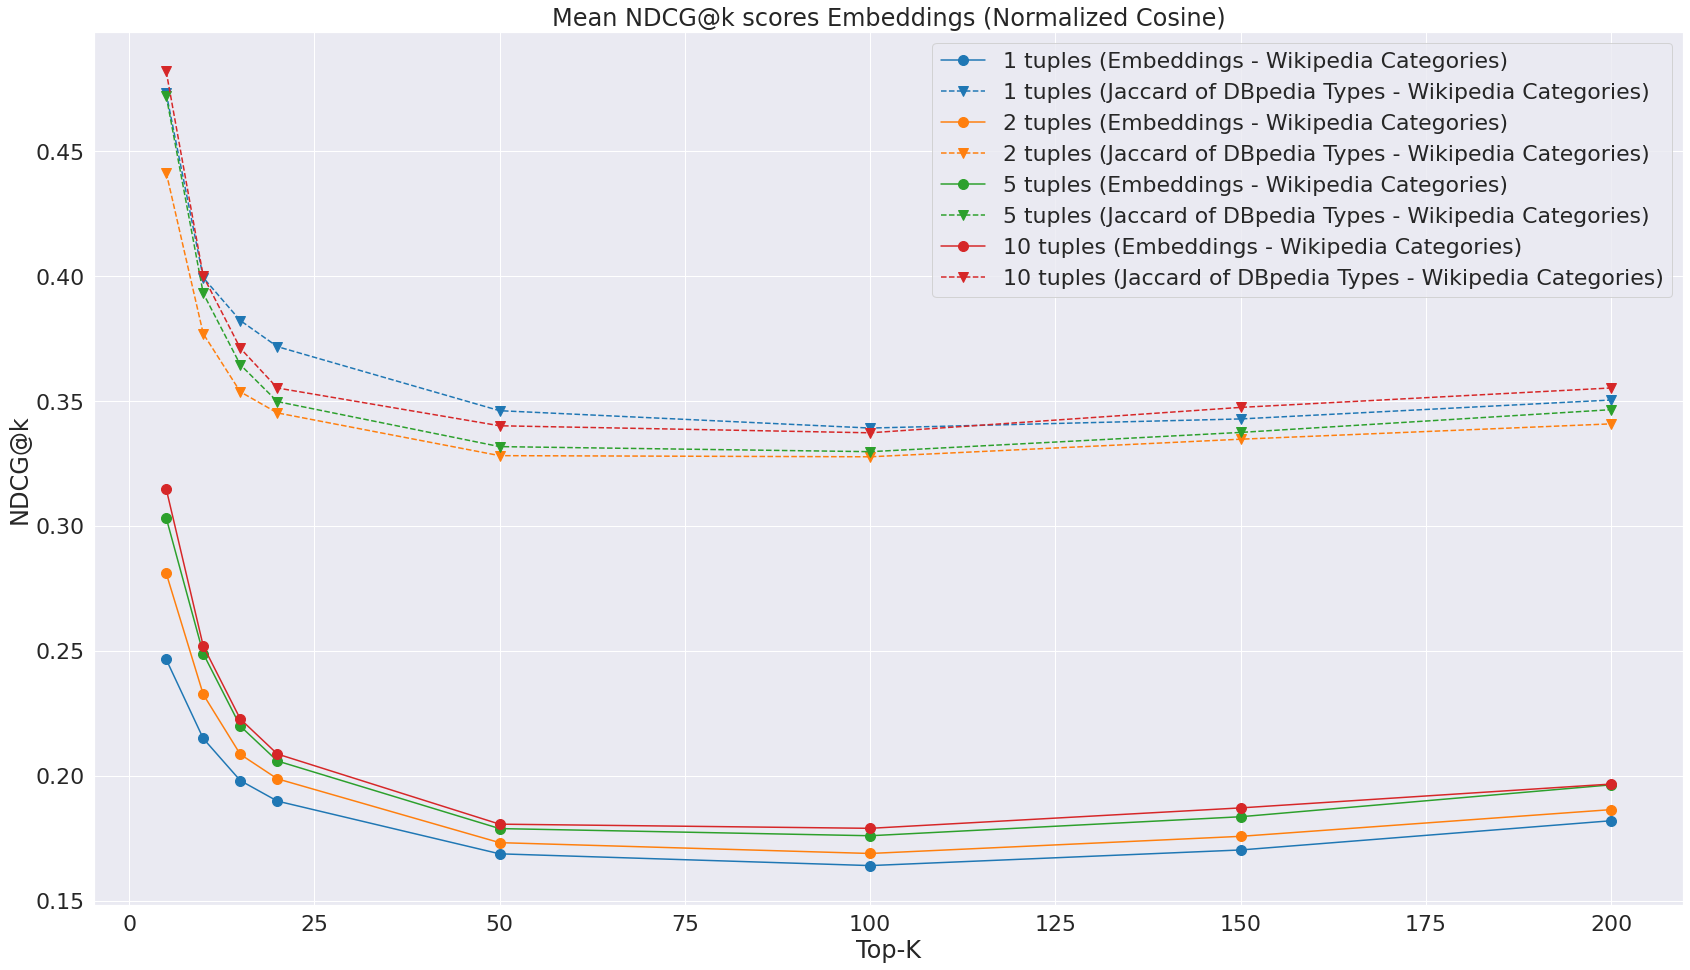

In [32]:
mean_ndcg_scores_norm_cos_jaccard_categories = get_mean_ndcg_scores_at_k(embeddings_query_dfs_dict['norm_cos']['jaccard_categories'], top_k_vals, tuples_per_query_list)
mean_ndcg_scores_norm_cos_jaccard_navigation_links = get_mean_ndcg_scores_at_k(embeddings_query_dfs_dict['norm_cos']['jaccard_navigation_links'], top_k_vals, tuples_per_query_list)

fig = plt.figure();ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_norm_cos_jaccard_categories[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Embeddings - Wikipedia Categories)')

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_categories[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Jaccard of DBpedia Types - Wikipedia Categories)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Embeddings (Normalized Cosine)');plt.tight_layout()
plt.savefig('figures/filtered_queries/topk_ndcg@k_embeddings_vs_adjusted_jaccard_types_normalized_cosine_jaccard_categories.svg')

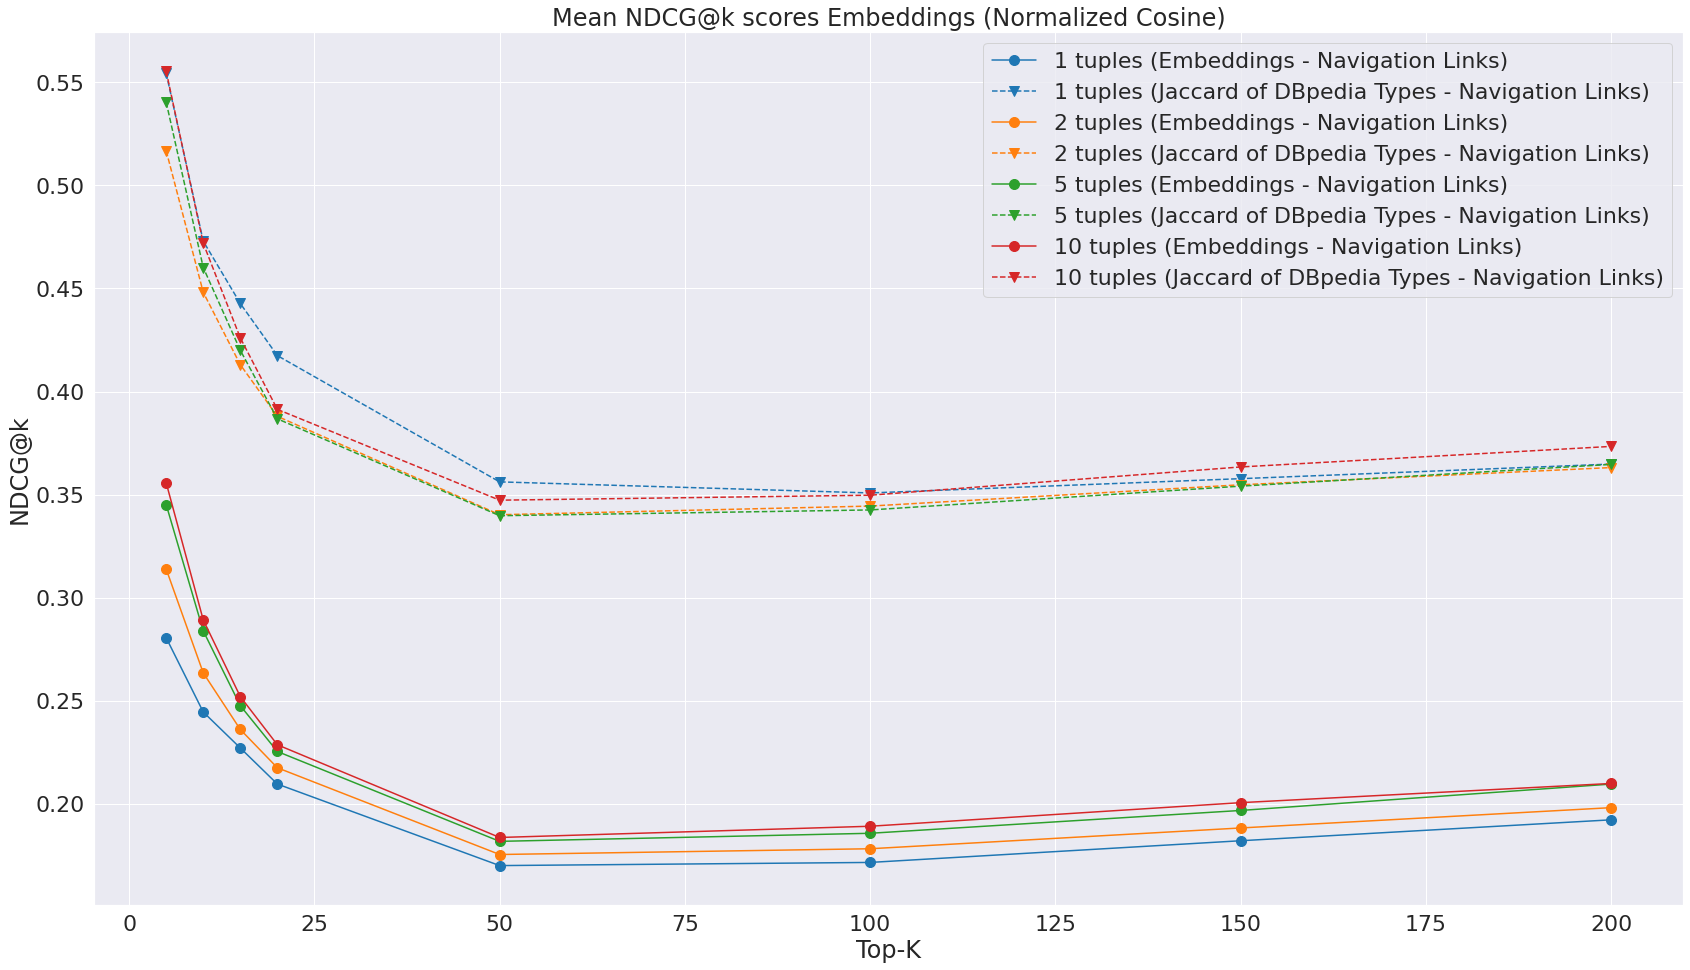

In [33]:
fig = plt.figure();ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_norm_cos_jaccard_navigation_links[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Embeddings - Navigation Links)')

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_navigation_links[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Jaccard of DBpedia Types - Navigation Links)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Embeddings (Normalized Cosine)');plt.tight_layout()
plt.savefig('figures/filtered_queries/topk_ndcg@k_embeddings_vs_adjusted_jaccard_types_normalized_cosine_jaccard_navigation_links.svg')

## Search Mode: BM25

In [24]:
full_df_path="../../data/queries/wikipages/query_dataframes/minTupleWidth_all_tuplesPerQuery_all.pickle"
full_df = pd.read_pickle(full_df_path)
groundtruth_relevance_scores_dir_categories='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/jaccard_categories/'
groundtruth_relevance_scores_dir_navigation_links='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/jaccard_navigation_links/'
tables_path = '../../data/tables/wikipages/wikipages_dataset/tables/'

# Extract the names of all tables in our search space
tables_list = os.listdir(tables_path)

In [25]:
bm25_scores_base_path='../../Web-Table-Retrieval-Benchmark/data/wikipages/ranking/filtered_queries/'

# Dictionary keyed by tuples per query and maps to another dictionary keyed by 'entities' and 'text'
# which in turn map to a dictionary keyed by 'catchall', 'content', etc. and map to their respective dataframes with NDCG scores
dfs_dict = {}

for tuples_per_query in tqdm(tuples_per_query_list):
    base_num_tuples_path='minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_'+str(tuples_per_query)
    bm25_scores_path_entities = bm25_scores_base_path+base_num_tuples_path+'/entities/'
    bm25_scores_path_text = bm25_scores_base_path+base_num_tuples_path+'/text/'

    # Read the query dataframe
    df = pd.read_pickle(query_df_base_dir + base_num_tuples_path+'.pickle')

    # Construct the modified dataframes with the NDCG scores

    # Text Queries
    df_content_text_categories = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_text+'content.txt',
        k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_categories)
    df_content_text_navigation_links = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_text+'content.txt',
        k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_navigation_links)

    # Entity Queries
    df_content_entities_categories = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_entities+'content.txt',
        k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_categories)
    df_content_entities_navigation_links = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_entities+'content.txt',
        k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_navigation_links)

    # Update dfs_dict
    dfs_dict[tuples_per_query] = {}
    dfs_dict[tuples_per_query]['entities'] = {'content_categories': df_content_entities_categories, 'content_navigation_links': df_content_entities_navigation_links}
    dfs_dict[tuples_per_query]['text'] = {'content_categories': df_content_text_categories,'content_navigation_links': df_content_text_navigation_links} 

with open('evaluation_dataframes/filtered_queries_bm25_dfs_dict.pickle', 'wb') as handle:
    pickle.dump(dfs_dict, handle)

100%|██████████| 4/4 [01:29<00:00, 22.31s/it]


In [28]:
with open('evaluation_dataframes/filtered_queries_bm25_dfs_dict.pickle', 'rb') as handle:
    dfs_dict = pickle.load(handle)

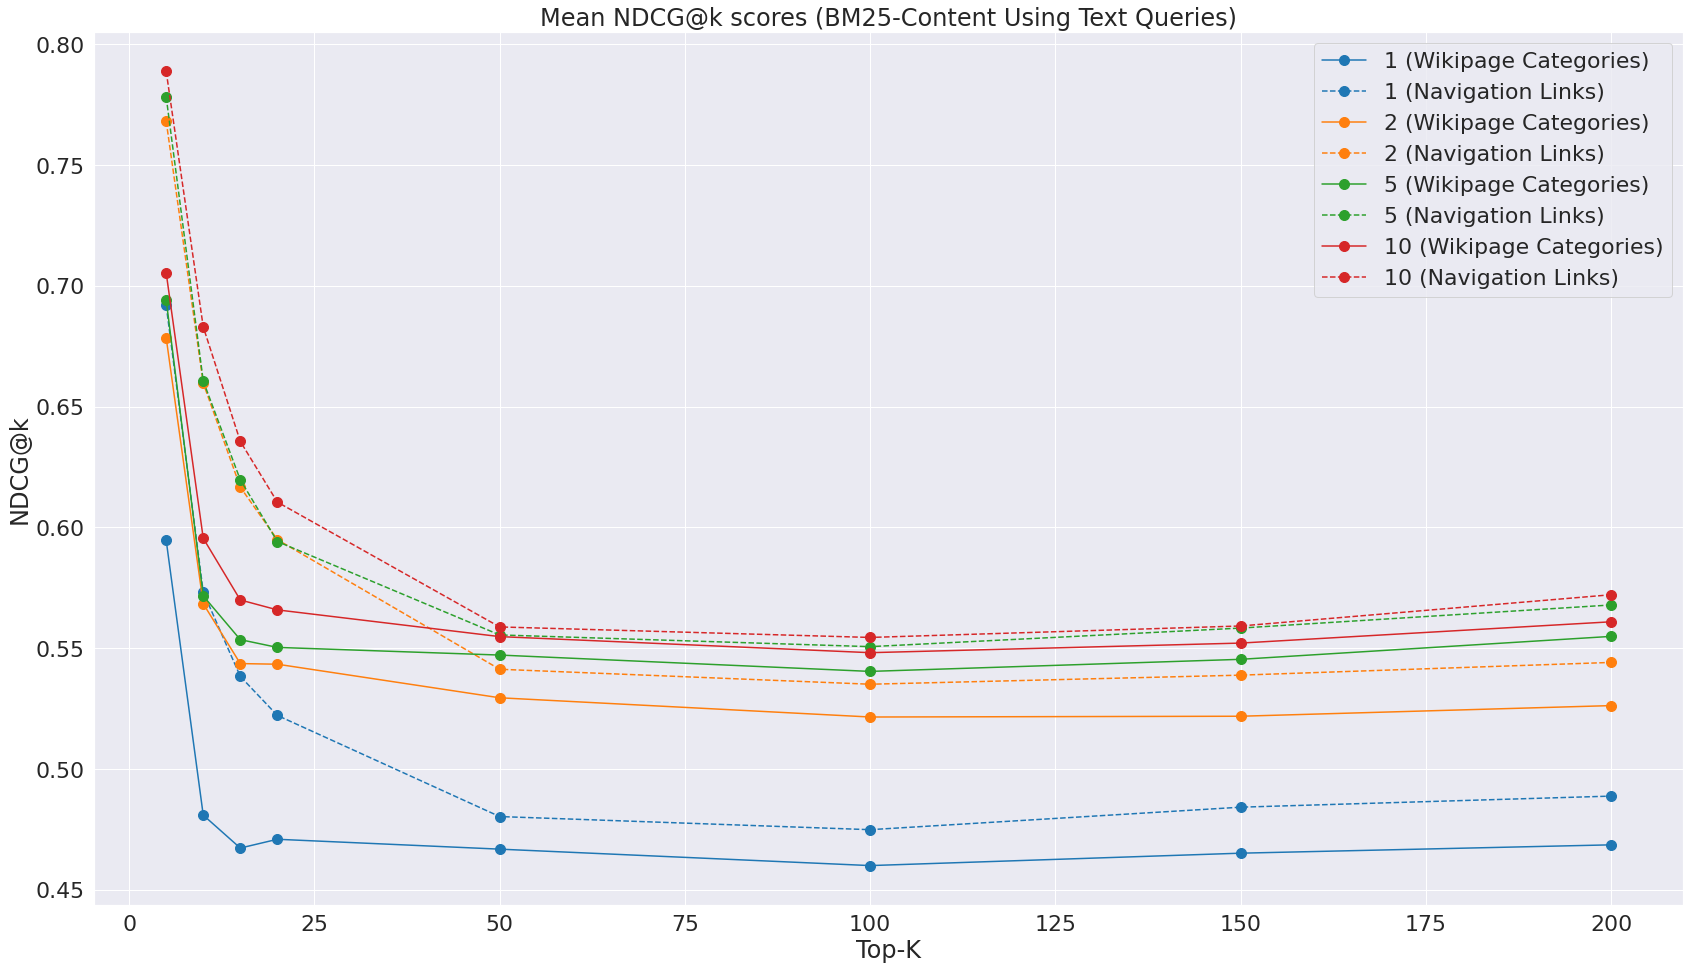

In [32]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]
    mean_ndcg_scores_at_k_navigation_links = [dfs_dict[tuples_per_query_list[i]]['text']['content_navigation_links']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_navigation_links, '--', marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Navigation Links)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Text Queries)');plt.tight_layout()
plt.savefig('figures/filtered_queries/topk_ndcg@k_bm25_text_queries_categories_vs_navigation_links.svg')

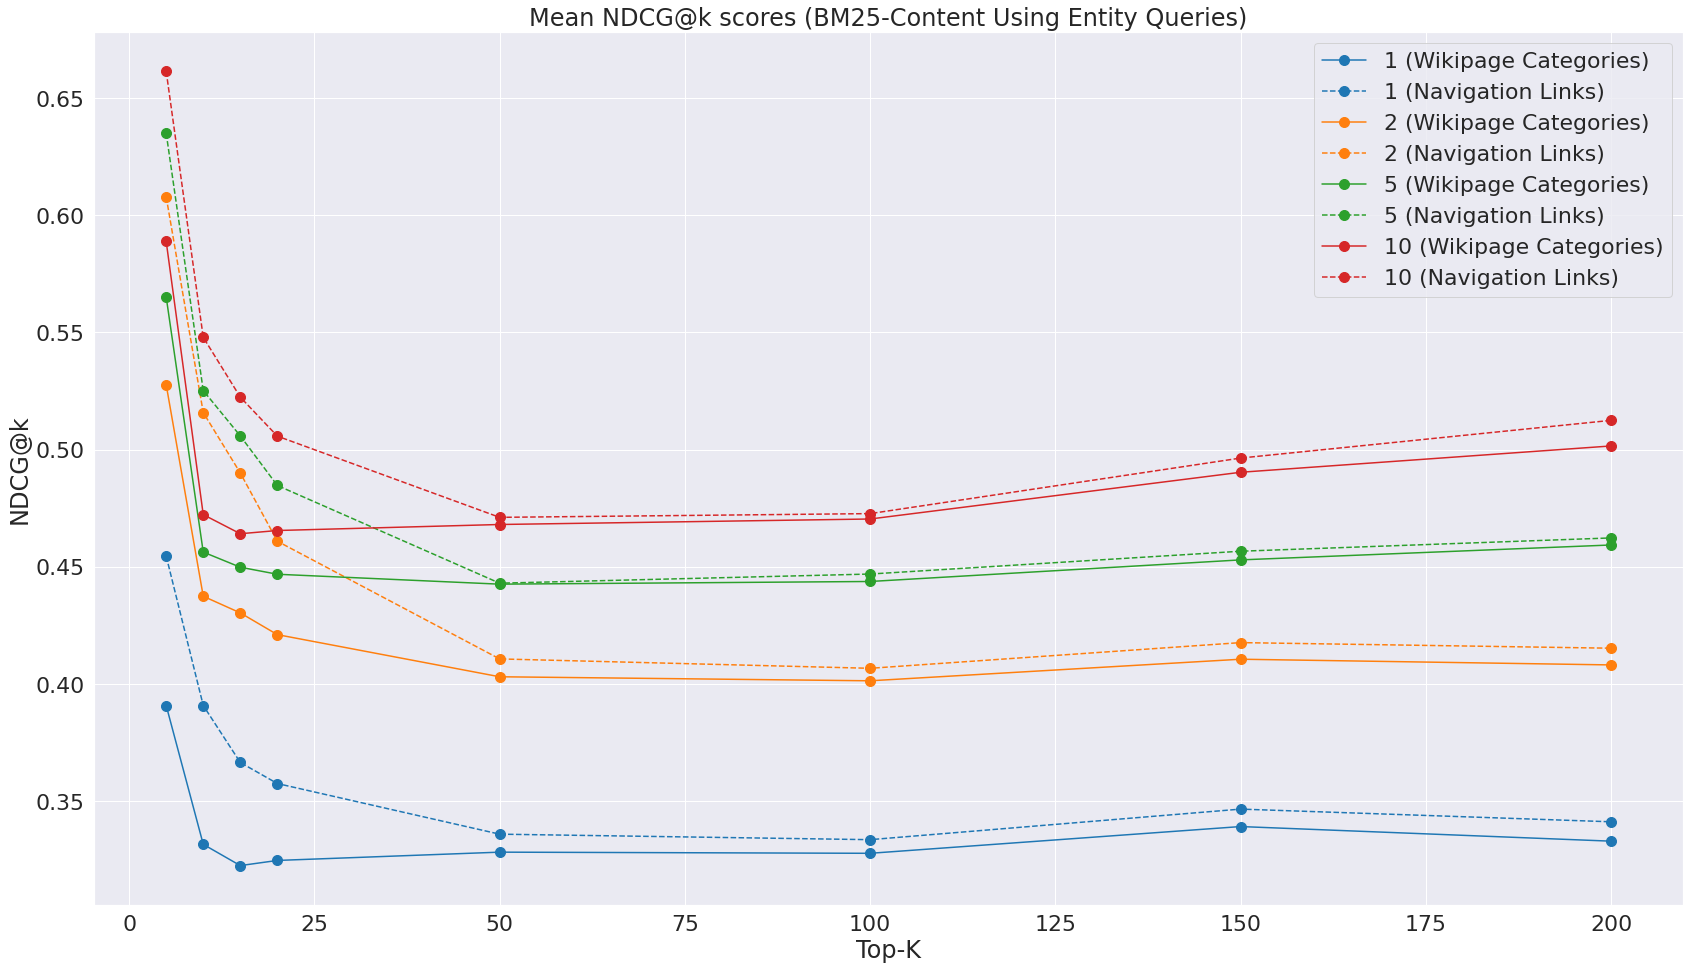

In [34]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]
    mean_ndcg_scores_at_k_navigation_links = [dfs_dict[tuples_per_query_list[i]]['entities']['content_navigation_links']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_navigation_links, '--', marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Navigation Links)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Entity Queries)');plt.tight_layout()
plt.savefig('figures/filtered_queries/topk_ndcg@k_bm25_entity_queries_categories_vs_navigation_links.svg')

## Compare BM25 Entity Queries vs. Adjusted Jaccard of DBpedia Types (Navigation Links)

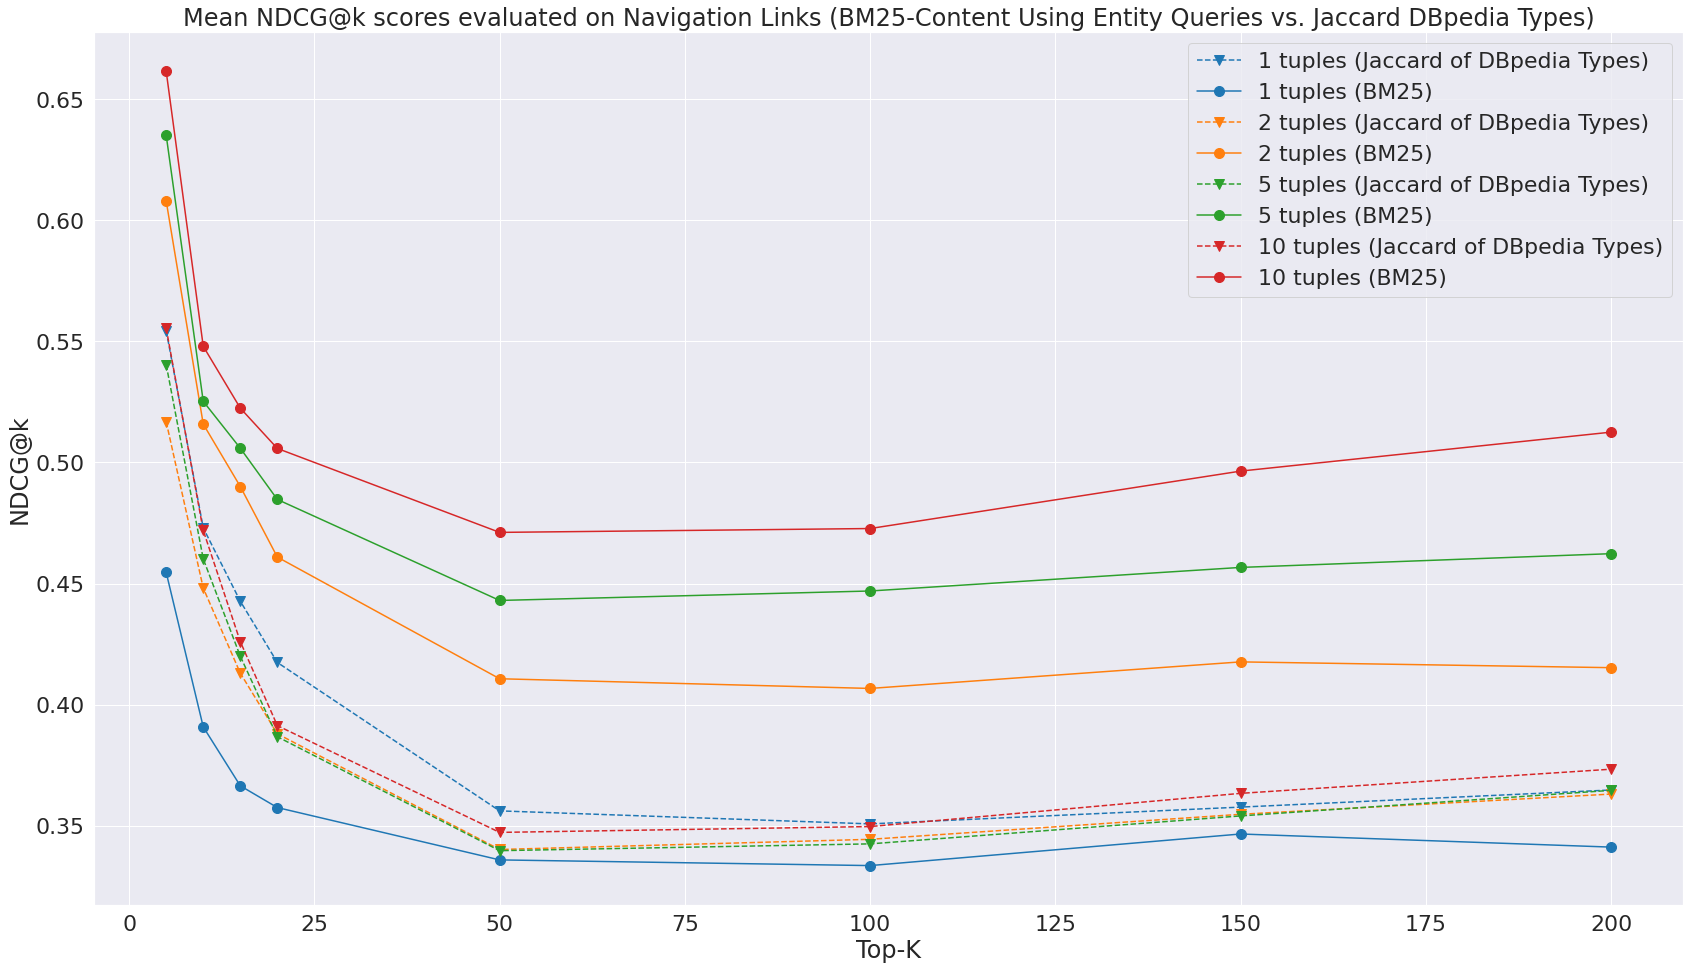

In [39]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):

    mean_ndcg_scores_at_k_navigation_links = [dfs_dict[tuples_per_query_list[i]]['entities']['content_navigation_links']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_navigation_links[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Jaccard of DBpedia Types)')

    # plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_navigation_links, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' tuples (BM25)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores evaluated on Navigation Links (BM25-Content Using Entity Queries vs. Jaccard DBpedia Types)');plt.tight_layout()
plt.savefig('figures/filtered_queries/topk_ndcg@k_bm25_entity_queries_vs_adjusted_jaccard.svg')

## Query Results Exploration

In [36]:
def get_exploration_summary(wikipage_id, queries_dir, search_output_dir, groundtruth_relevance_scores_dir):

    with open(queries_dir + 'wikipage_' + str(wikipage_id) + '.json') as fp:
        query = json.load(fp)['queries']
    print("Query:\n", query)

    with open(search_output_dir + 'wikipage_' + str(wikipage_id) + '/search_output/filenameToScore.json') as fp:
        scores = json.load(fp)['scores']
    print("\nWikipage titles of top scored tables:\n", [table['pgTitle'] for table in scores[:10]])

    with open(groundtruth_relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        wikipage_relevance_scores = json.load(fp)
    print("\nGroundtruth Wikipages relevance scores:\n", wikipage_relevance_scores)

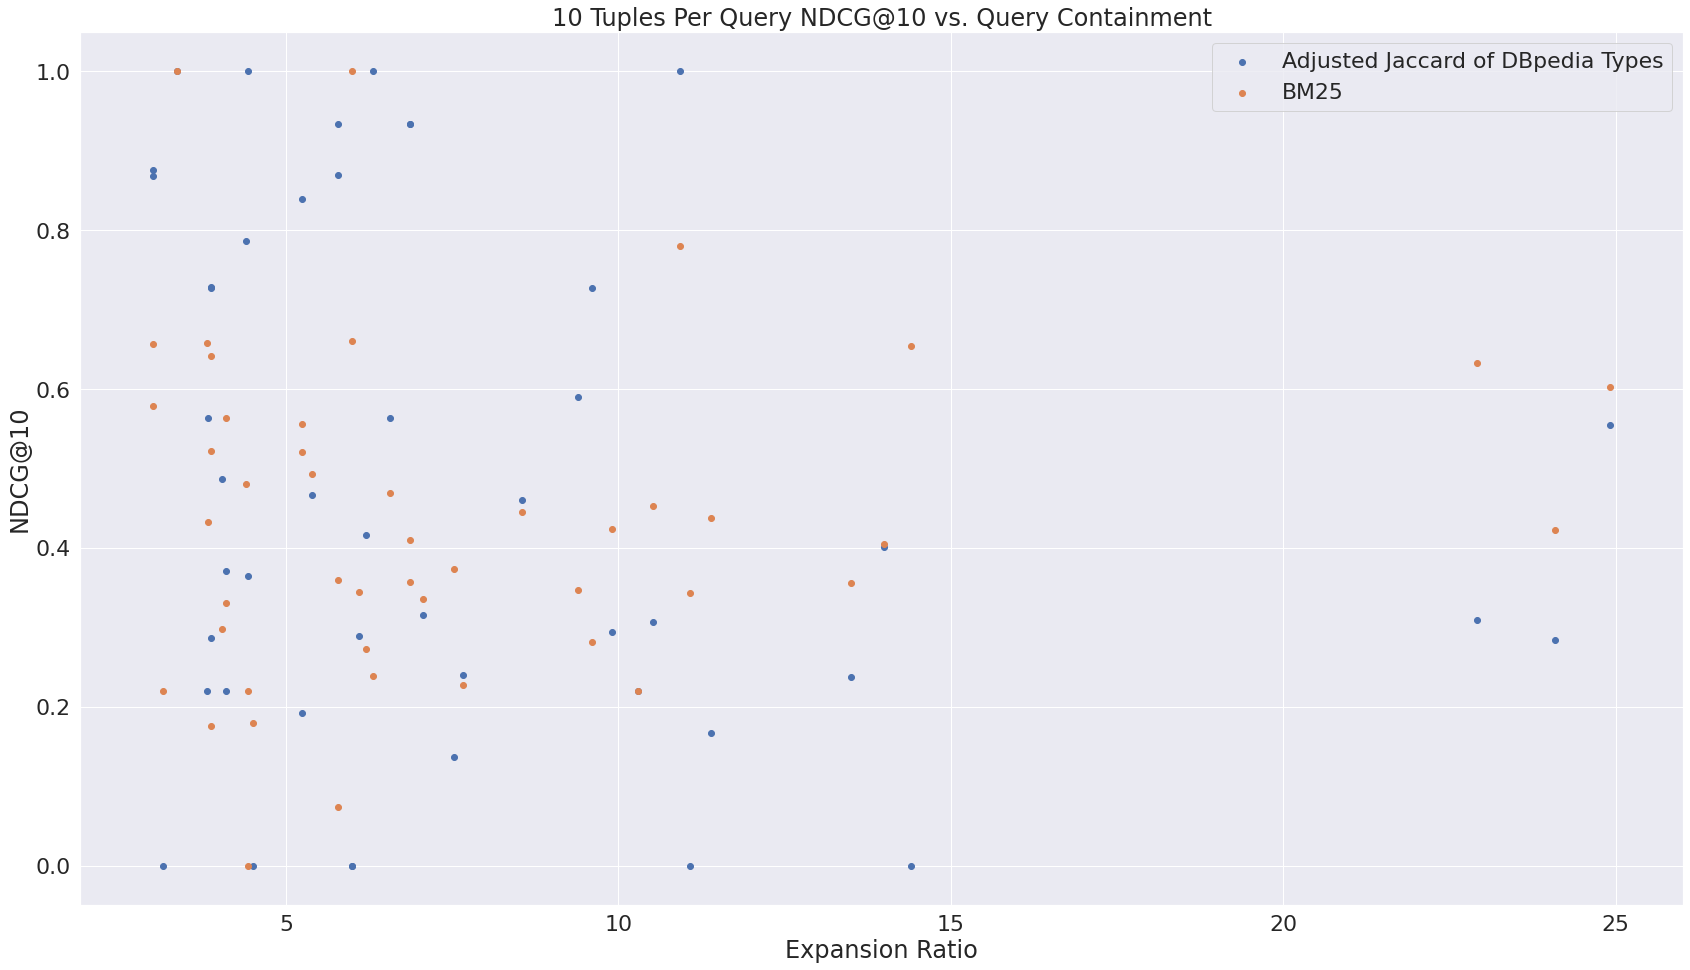

In [38]:
plt.scatter(query_df_adjusted_jaccard_navigation_links[10]['navigation_links_expansion_ratio'], query_df_adjusted_jaccard_navigation_links[10]['ndcg@10'], label='Adjusted Jaccard of DBpedia Types')
plt.scatter(dfs_dict[10]['entities']['content_navigation_links']['navigation_links_expansion_ratio'], dfs_dict[10]['entities']['content_navigation_links']['ndcg@10'], label='BM25')
plt.legend()
plt.xlabel('Expansion Ratio');plt.ylabel('NDCG@10');plt.title('10 Tuples Per Query NDCG@10 vs. Query Containment');plt.tight_layout()
# plt.savefig('figures/wikipage_categories/brute_force_jaccard_ndcg10_vs_query_containment.svg')

In [48]:
queries_dir = '../../data/queries/wikipages/queries/filtered_queries/minTupleWidth_2_tuplesPerQuery_10/'
search_output_dir = '../../data/search/wikipages/filtered_queries/minTupleWidth_2_tuplesPerQuery_10/adjusted_jaccard/'
groundtruth_relevance_scores_dir_navigation_links='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_dataset/jaccard_navigation_links/'

In [44]:
jaccard_df = query_df_adjusted_jaccard_navigation_links[10].sort_values(by='ndcg@10').head(10)
jaccard_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,categories_relevant_wikipages,...,categories_expansion_ratio,navigation_links_expansion_ratio,ndcg@20,ndcg@50,ndcg@15,ndcg@200,ndcg@10,ndcg@100,ndcg@5,ndcg@150
202834,https://en.wikipedia.org/wiki/List_of_United_S...,202834,21,"[table-1383-71.json, table-1383-72.json, table...","[24, 24, 55, 45, 147, 14, 12, 55, 65, 111, 107...",3.0,10.0,table-1383-75.json,"[13, 15, 17, 20, 21, 32, 45, 54, 67, 75]",5.0,...,3.619048,6.000000,0.000000,0.006218,0.000000,0.026435,0.000000,0.013661,0.000000,0.013146
134205,https://en.wikipedia.org/wiki/List_of_United_S...,134205,12,"[table-0915-663.json, table-0915-664.json, tab...","[116, 101, 111, 31, 42, 28, 18, 77, 10, 37, 32...",3.0,10.0,table-0915-664.json,"[5, 13, 15, 17, 18, 19, 20, 29, 30, 33]",17.0,...,17.583333,4.500000,0.000000,0.000000,0.000000,0.103480,0.000000,0.012260,0.000000,0.054122
6657,https://en.wikipedia.org/wiki/List_of_Alpha_Ph...,6657,13,"[table-0044-730.json, table-0044-732.json, tab...","[42, 39, 45, 40, 23, 58, 63, 41, 36, 83, 22, 2...",3.0,10.0,table-0044-743.json,"[2, 6, 7, 10, 11, 12, 13, 16, 19, 24]",4.0,...,4.000000,3.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
131934,https://en.wikipedia.org/wiki/List_of_Desert_I...,131934,10,"[table-0899-332.json, table-0899-333.json, tab...","[114, 92, 123, 111, 94, 110, 70, 90, 92, 84]",3.0,10.0,table-0899-334.json,"[1, 4, 7, 8, 9, 11, 12, 13, 14, 15]",7.0,...,7.400000,6.000000,0.000000,0.000000,0.000000,0.055892,0.000000,0.000000,0.000000,0.019263
216609,https://en.wikipedia.org/wiki/Academy_Award_fo...,216609,10,"[table-1469-487.json, table-1469-488.json, tab...","[57, 15, 15, 64, 100, 89, 79, 47, 52, 57]",3.0,10.0,table-1469-491.json,"[4, 5, 9, 10, 16, 23, 26, 28, 35, 41]",11.0,...,14.400000,14.400000,0.098252,0.141643,0.065461,0.304911,0.000000,0.188110,0.000000,0.252613
218901,https://en.wikipedia.org/wiki/List_of_Olympic_...,218901,12,"[table-1485-910.json, table-1485-911.json, tab...","[42, 34, 88, 40, 79, 86, 89, 63, 80, 81, 81, 79]",4.0,10.0,table-1485-923.json,"[4, 6, 7, 10, 11, 12, 13, 15, 16, 17]",7.0,...,7.750000,11.083333,0.006038,0.050591,0.006664,0.118678,0.000000,0.067947,0.000000,0.083833
35537,https://en.wikipedia.org/wiki/List_of_Olympic_...,35537,15,"[table-0250-25.json, table-0250-26.json, table...","[53, 37, 33, 47, 92, 56, 35, 83, 40, 72, 41, 7...",4.0,10.0,table-0250-29.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",12.0,...,12.533333,7.533333,0.199607,0.482187,0.239755,0.553077,0.136985,0.550733,0.000000,0.553077
160233,https://en.wikipedia.org/wiki/List_of_Olympic_...,160233,10,"[table-1094-356.json, table-1094-357.json, tab...","[52, 26, 22, 25, 53, 51, 26, 55, 54, 53]",4.0,10.0,table-1094-366.json,"[0, 1, 3, 4, 5, 7, 8, 9, 10, 12]",4.0,...,4.200000,11.400000,0.194178,0.331230,0.181991,0.422079,0.166639,0.365899,0.181802,0.416412
31751,https://en.wikipedia.org/wiki/List_of_Game_Boy...,31751,12,"[table-0224-872.json, table-0224-874.json, tab...","[20, 15, 13, 14, 11, 74, 71, 51, 76, 17, 36, 41]",3.0,10.0,table-0224-879.json,"[4, 12, 14, 17, 18, 22, 25, 26, 37, 40]",4.0,...,5.250000,5.250000,0.194069,0.305468,0.153595,0.369980,0.192516,0.350146,0.132856,0.369980
228124,https://en.wikipedia.org/wiki/List_of_top-divi...,228124,17,"[table-1550-995.json, table-1551-10.json, tabl...","[29, 10, 14, 19, 11, 12, 14, 15, 40, 14, 13, 1...",3.0,10.0,table-1551-33.json,"[0, 1, 2, 4, 7, 8, 9, 10, 12, 13]",4.0,...,5.294118,10.294118,0.147005,0.095157,0.170609,0.130279,0.220092,0.080155,0.339160,0.092110


In [52]:
get_exploration_summary(218901, queries_dir, search_output_dir, groundtruth_relevance_scores_dir_navigation_links)

Query:
 [['http://dbpedia.org/resource/Boxing_at_the_1936_Summer_Olympics', 'http://dbpedia.org/resource/Roger_Michelot', 'http://dbpedia.org/resource/Richard_Vogt', 'http://dbpedia.org/resource/Francisco_Risiglione'], ['http://dbpedia.org/resource/Boxing_at_the_1952_Summer_Olympics', 'http://dbpedia.org/resource/Norvel_Lee', 'http://dbpedia.org/resource/Antonio_Pacenza', 'http://dbpedia.org/resource/Anatoly_Perov'], ['http://dbpedia.org/resource/Boxing_at_the_1952_Summer_Olympics', 'http://dbpedia.org/resource/Norvel_Lee', 'http://dbpedia.org/resource/Antonio_Pacenza', 'http://dbpedia.org/resource/Harry_Siljander'], ['http://dbpedia.org/resource/Boxing_at_the_1960_Summer_Olympics', 'http://dbpedia.org/resource/Muhammad_Ali', 'http://dbpedia.org/resource/Zbigniew_Pietrzykowski', 'http://dbpedia.org/resource/Anthony_Madigan'], ['http://dbpedia.org/resource/Boxing_at_the_1960_Summer_Olympics', 'http://dbpedia.org/resource/Muhammad_Ali', 'http://dbpedia.org/resource/Zbigniew_Pietrzykowski

# Expanded Wikipages Dataset

In [22]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/filtered_queries/'
min_tuple_width=2
tuples_per_query_list = [1, 2]
top_k_vals = [5,10,15,20,50,100,150,200,400,800]

## Search Mode: Adjusted Jaccard of DBpedia Types

In [23]:
search_mode='adjusted_jaccard'
adj_jaccard_score_paths_base_dir = 'eval_over_search_output/wikipages_expanded/filtered_queries/adjusted_jaccard/'

# Updated Dataframes for Wikipages with Categories (Adjusted Jaccard)
query_df_adjusted_jaccard_categories = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

# Updated Dataframes for Wikipages with Categories (Adjusted Jaccard)
query_df_adjusted_jaccard_navigation_links = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_navigation_links',
    tuples_per_query_list=tuples_per_query_list
)

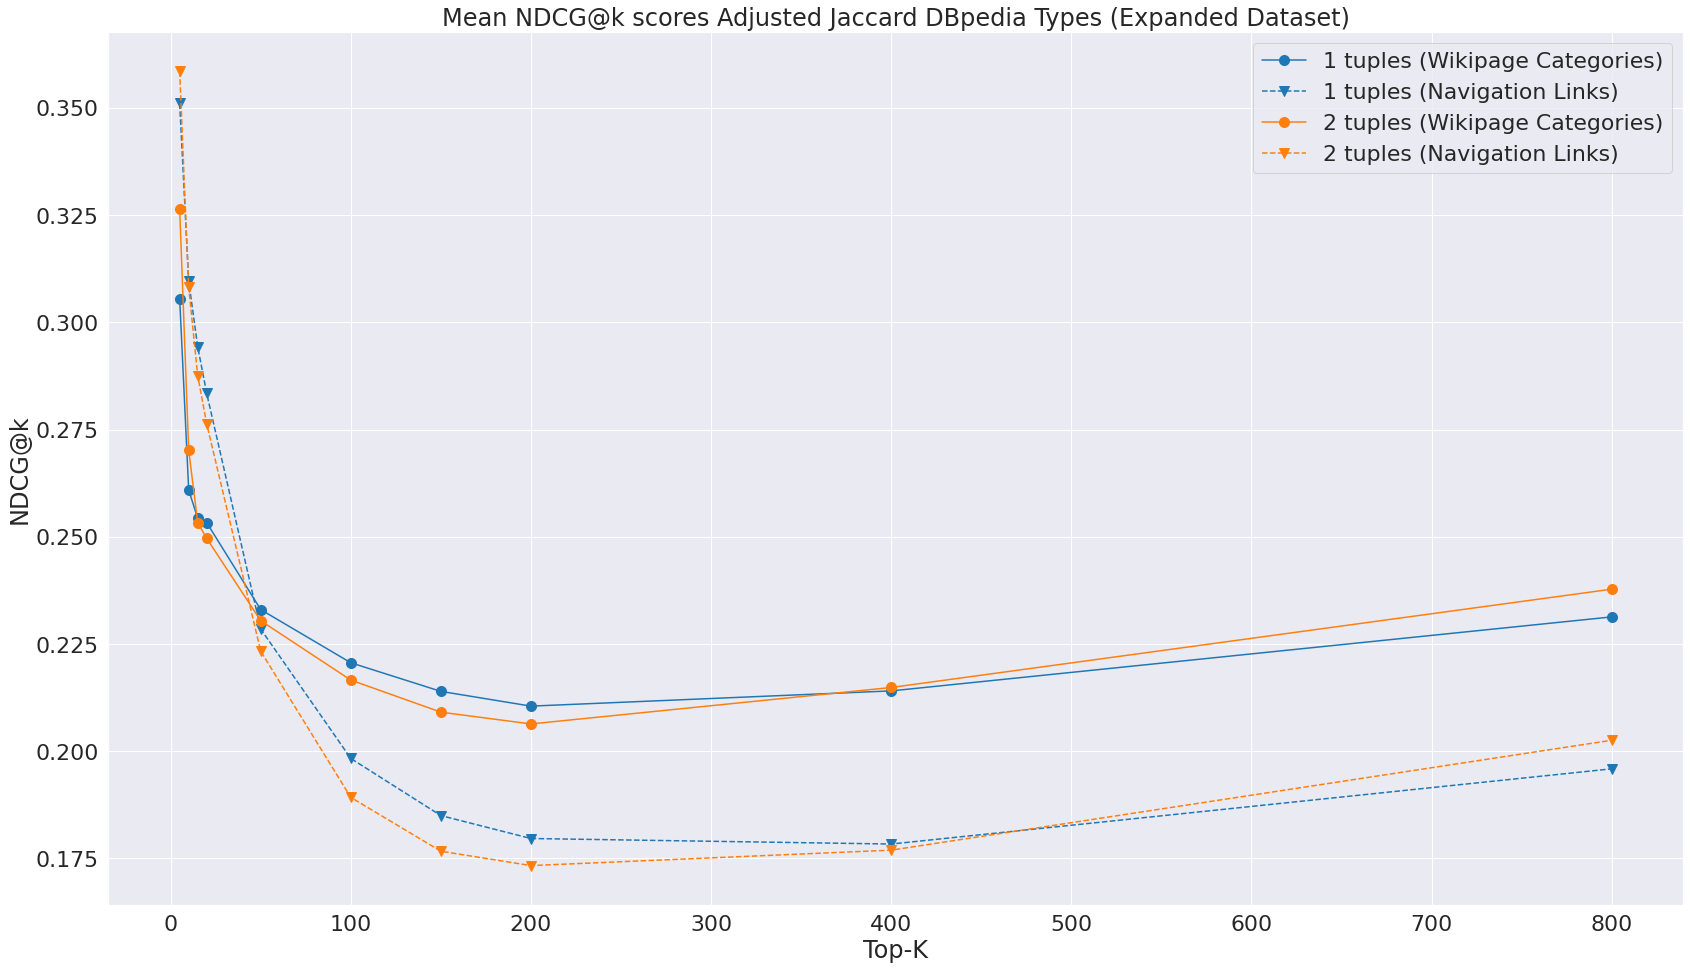

In [26]:
# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
mean_ndcg_scores_at_k_adjusted_jaccard_categories = get_mean_ndcg_scores_at_k(query_df_adjusted_jaccard_categories, top_k_vals, tuples_per_query_list)
mean_ndcg_scores_at_k_adjusted_jaccard_navigation_links = get_mean_ndcg_scores_at_k(query_df_adjusted_jaccard_navigation_links, top_k_vals, tuples_per_query_list)

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_categories[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_navigation_links[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Navigation Links)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard DBpedia Types (Expanded Dataset)');plt.tight_layout()
plt.savefig('figures/filtered_queries/expanded_wikipages_dataset_topk_ndcg@k_adjusted_jaccard_types_categories_vs_navigation_links.svg')

## Search Mode: BM25

In [5]:
full_df_path="../../data/tables/wikipages/wikipages_expanded_dataset/wikipages_df.pickle"
full_df = pd.read_pickle(full_df_path)
groundtruth_relevance_scores_dir_categories='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/jaccard_categories/'
groundtruth_relevance_scores_dir_navigation_links='../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/jaccard_navigation_links/'
tables_path = '../../data/tables/wikipages/wikipages_expanded_dataset/tables/'

# Extract the names of all tables in our search space
tables_list = os.listdir(tables_path)

In [ ]:
# bm25_scores_base_path='../../Web-Table-Retrieval-Benchmark/data/wikipages_expanded/ranking/filtered_queries/'

# # Dictionary keyed by tuples per query and maps to another dictionary keyed by 'entities' and 'text'
# # which in turn map to a dictionary keyed by 'catchall', 'content', etc. and map to their respective dataframes with NDCG scores
# dfs_dict = {}

# for tuples_per_query in tqdm(tuples_per_query_list):
#     base_num_tuples_path='minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_'+str(tuples_per_query)
#     bm25_scores_path_entities = bm25_scores_base_path+base_num_tuples_path+'/entities/'
#     bm25_scores_path_text = bm25_scores_base_path+base_num_tuples_path+'/text/'

#     # Read the query dataframe
#     df = pd.read_pickle(query_df_base_dir + base_num_tuples_path+'.pickle')

#     # Construct the modified dataframes with the NDCG scores

#     # Text Queries
#     df_content_text_categories = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_text+'content.txt',
#         k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_categories)
#     df_content_text_navigation_links = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_text+'content.txt',
#         k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_navigation_links)

#     # Entity Queries
#     df_content_entities_categories = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_entities+'content.txt',
#         k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_categories)
#     df_content_entities_navigation_links = utils.evaluation_helpers.get_updated_df(df=df.copy(), full_df=full_df, scores_path=bm25_scores_path_entities+'content.txt',
#         k_vals=top_k_vals, tables_list=tables_list, groundtruth_relevance_scores_dir=groundtruth_relevance_scores_dir_navigation_links)

#     # Update dfs_dict
#     dfs_dict[tuples_per_query] = {}
#     dfs_dict[tuples_per_query]['entities'] = {'content_categories': df_content_entities_categories, 'content_navigation_links': df_content_entities_navigation_links}
#     dfs_dict[tuples_per_query]['text'] = {'content_categories': df_content_text_categories,'content_navigation_links': df_content_text_navigation_links} 

# with open('evaluation_dataframes/wikipages_expanded_filtered_queries_bm25_dfs_dict.pickle', 'wb') as handle:
#     pickle.dump(dfs_dict, handle)

In [9]:
with open('evaluation_dataframes/wikipages_expanded_filtered_queries_bm25_dfs_dict.pickle', 'rb') as handle:
    dfs_dict = pickle.load(handle)

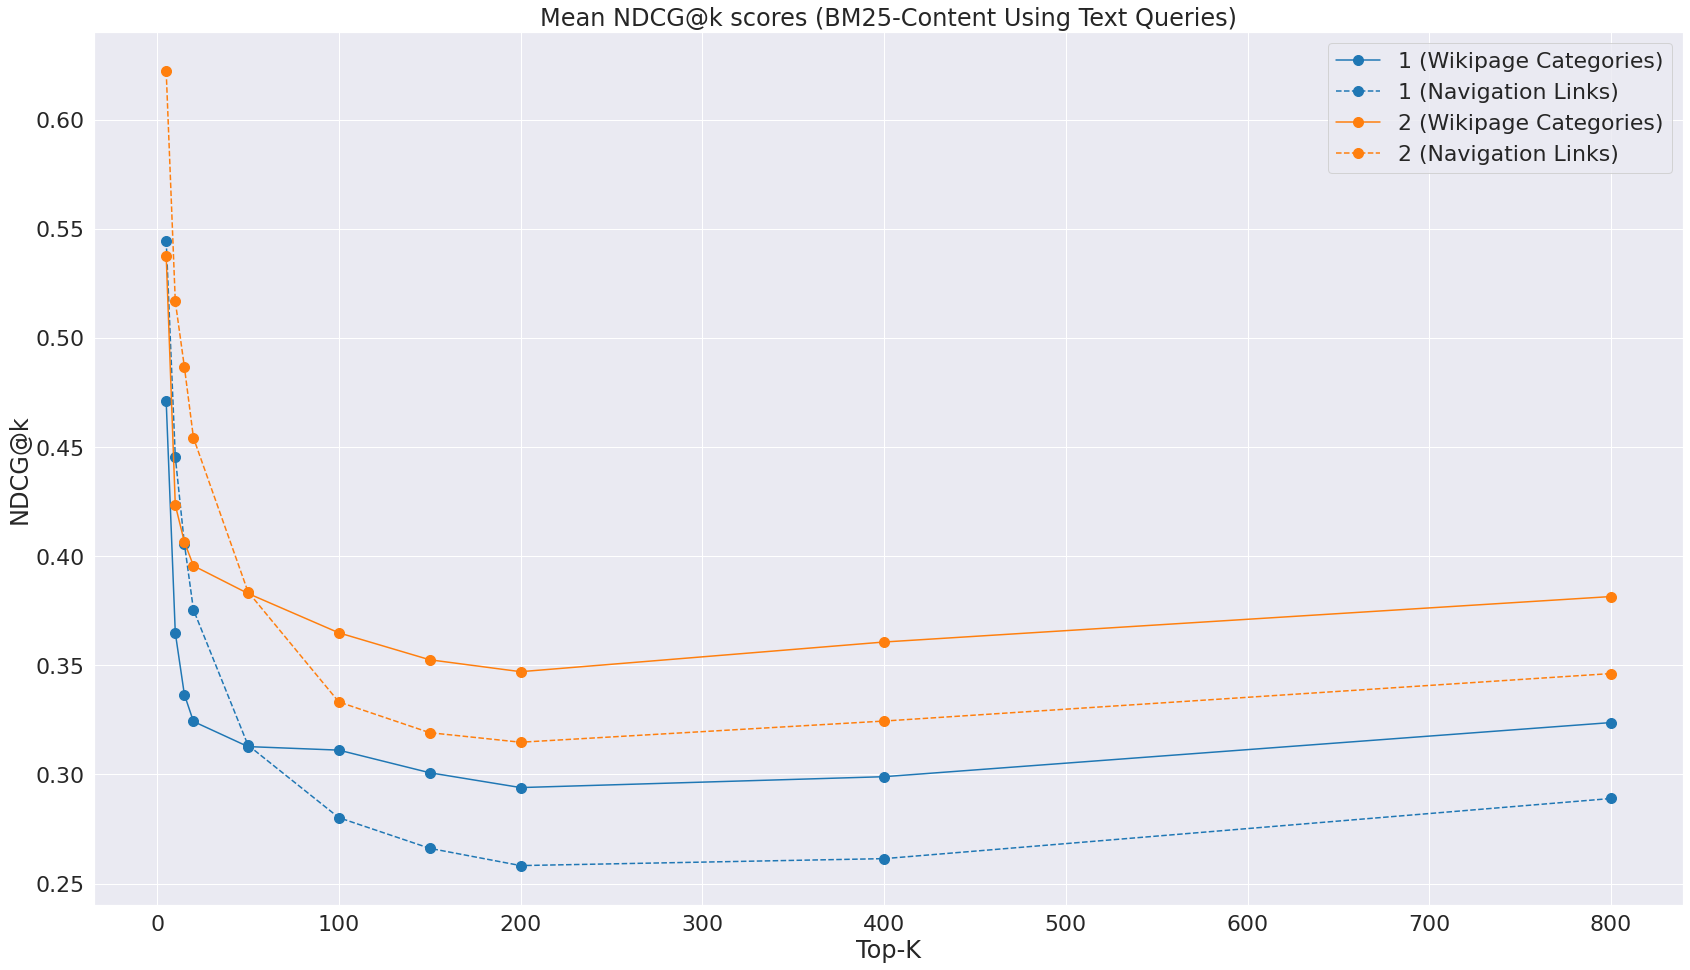

In [30]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]
    mean_ndcg_scores_at_k_navigation_links = [dfs_dict[tuples_per_query_list[i]]['text']['content_navigation_links']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_navigation_links, '--', marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Navigation Links)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Text Queries)');plt.tight_layout()
plt.savefig('figures/filtered_queries/expanded_wikipages_dataset_topk_ndcg@k_bm25_text_queries_categories_vs_navigation_links.svg')

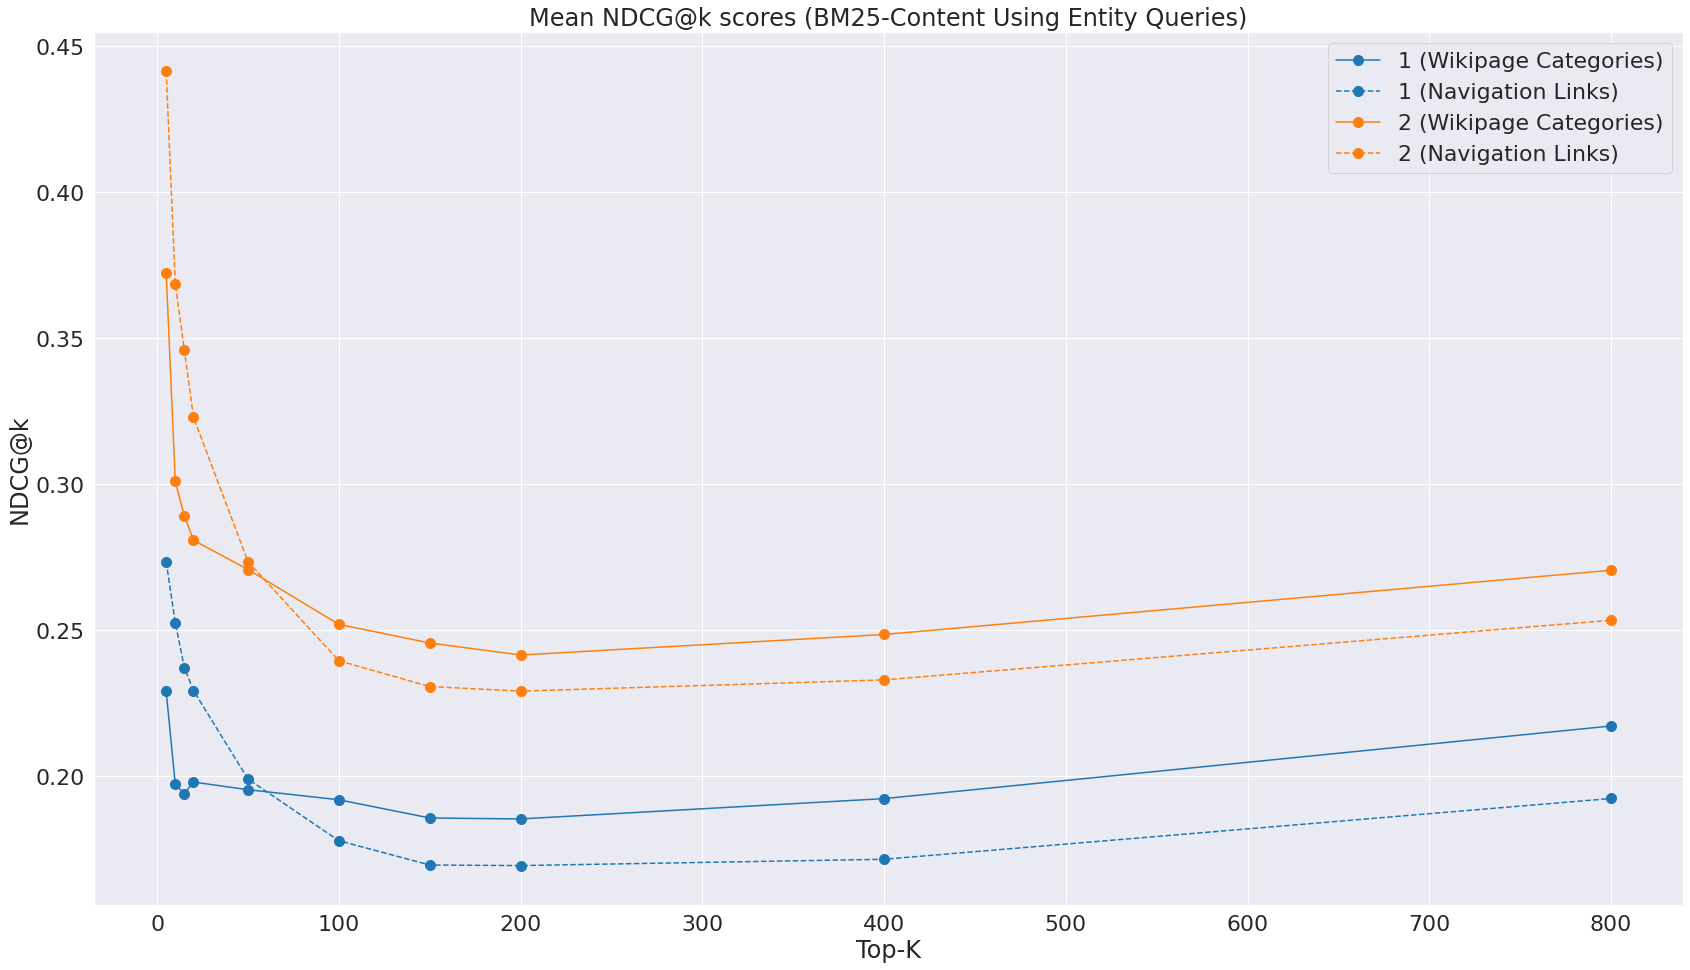

In [28]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]
    mean_ndcg_scores_at_k_navigation_links = [dfs_dict[tuples_per_query_list[i]]['entities']['content_navigation_links']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_navigation_links, '--', marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Navigation Links)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Entity Queries)');plt.tight_layout()
plt.savefig('figures/filtered_queries/expanded_wikipages_dataset_topk_ndcg@k_bm25_entity_queries_categories_vs_navigation_links.svg')

## Compare BM25 Entity Queries vs. Adjusted Jaccard of DBpedia Types (Navigation Links)

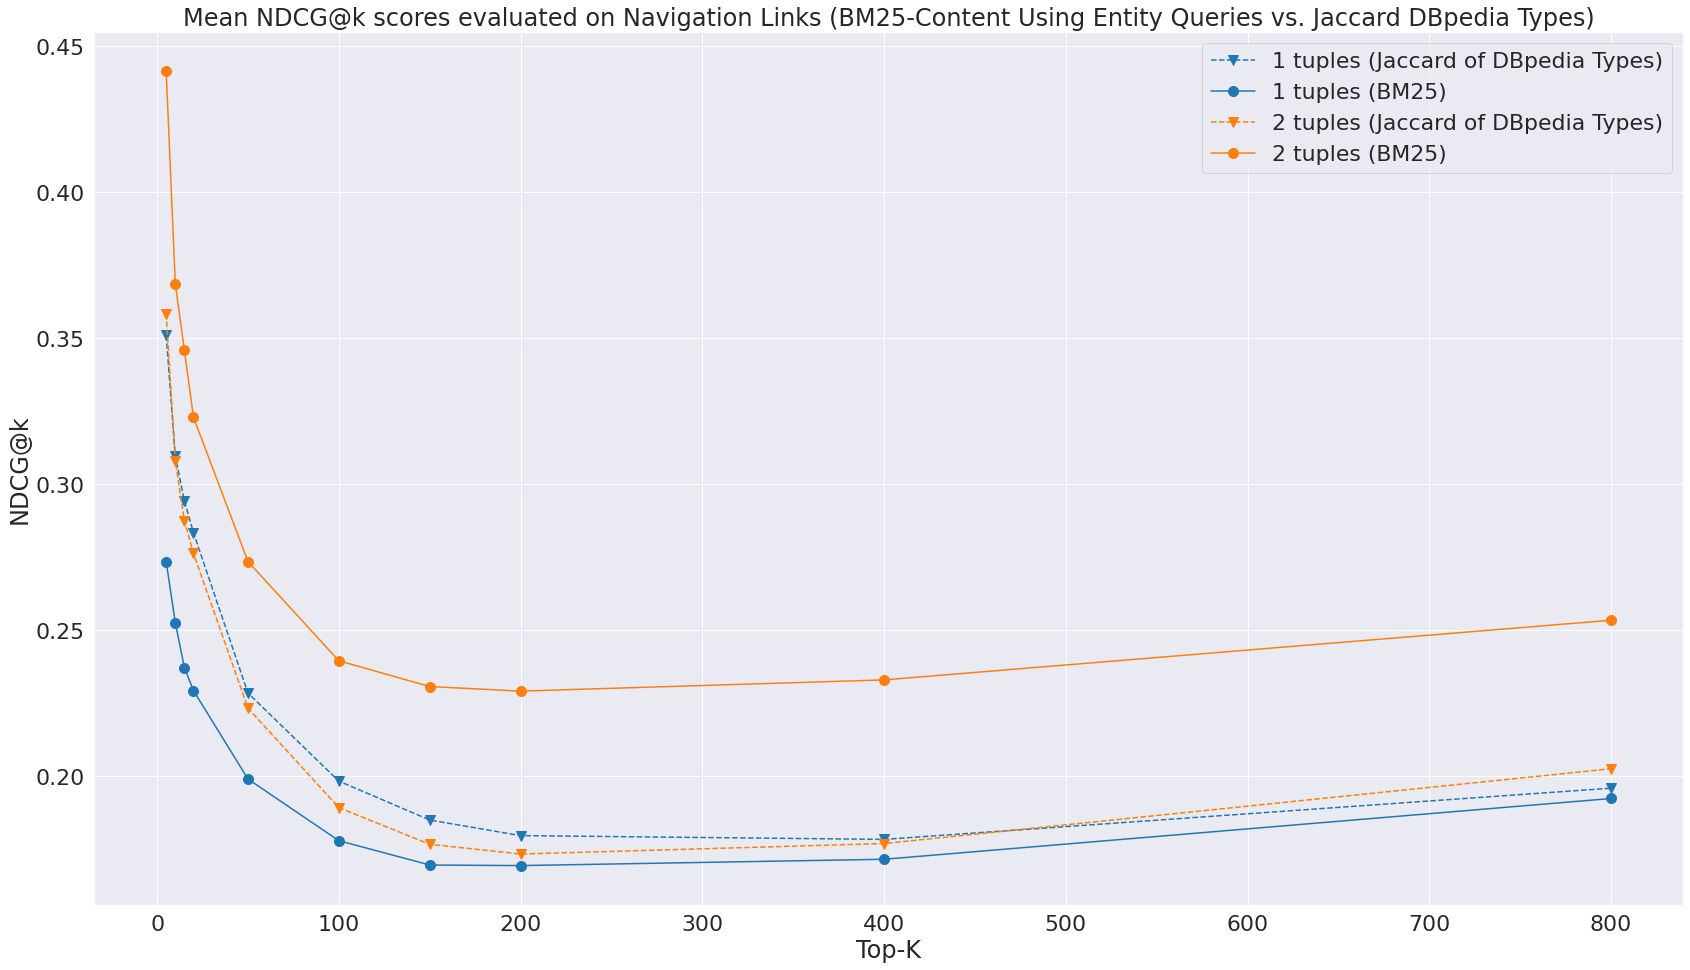

In [29]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):

    mean_ndcg_scores_at_k_navigation_links = [dfs_dict[tuples_per_query_list[i]]['entities']['content_navigation_links']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_navigation_links[tuples_per_query_list[i]], linestyle='dashed',
        marker='v', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Jaccard of DBpedia Types)')

    # plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_navigation_links, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' tuples (BM25)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores evaluated on Navigation Links (BM25-Content Using Entity Queries vs. Jaccard DBpedia Types)');plt.tight_layout()
plt.savefig('figures/filtered_queries/expanded_wikipages_dataset_topk_ndcg@k_bm25_entity_queries_vs_adjusted_jaccard.svg')